<a href="https://colab.research.google.com/github/Pratheek-05/ShadowFox-internship/blob/main/Advanced_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clearing cache for /root/.cache/huggingface/datasets/imdb


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pratheekkachinthaya (pratheekkachinthaya-nitte-meenakshi-institute-of-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.430300,0.319151
2,0.155300,0.381283


Evaluation Results: {'eval_loss': 0.38128331303596497, 'eval_runtime': 11.5155, 'eval_samples_per_second': 34.736, 'eval_steps_per_second': 4.342, 'epoch': 2.0}
Positive
Negative


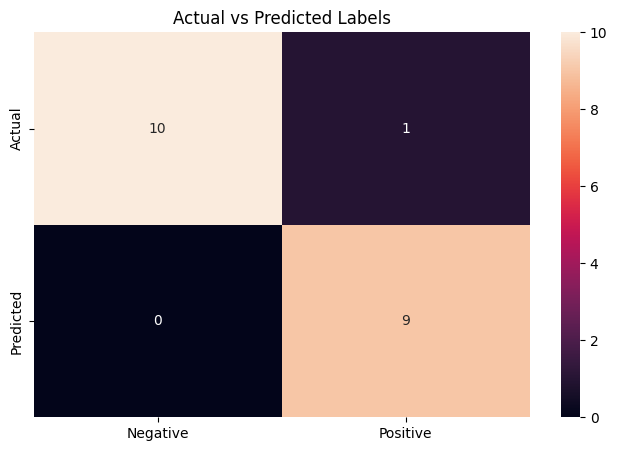


Conclusion:
- BERT performed well on sentiment classification.
- The model showed strong contextual understanding and handled complex sentence structures.
- However, inference time can be slow on CPU — making model distillation or quantization useful for production.



In [3]:
# Step 1: Install Required Libraries
!pip install transformers datasets matplotlib seaborn scikit-learn --quiet

# Step 2: Import Libraries
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, disable_caching
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix # Import confusion_matrix
import shutil
import os

# Step 3: Load Dataset
# Try loading the dataset again after updating
# Clear the cache for the "imdb" dataset to force a fresh download

# Construct the potential cache path for the imdb dataset
# A common cache location is ~/.cache/huggingface/datasets
cache_dir = os.path.join(os.path.expanduser('~'), '.cache', 'huggingface', 'datasets', 'imdb')

# Check if the cache directory exists and remove it
if os.path.exists(cache_dir):
    print(f"Clearing cache for {cache_dir}")
    shutil.rmtree(cache_dir)
else:
    print(f"Cache directory not found at {cache_dir}")

# Load the dataset. Caching is re-enabled by default after the script finishes
dataset = load_dataset("imdb")

# Access the 'train' split before shuffling and selecting
dataset = dataset['train'].shuffle(seed=42).select(range(2000))  # Reduce size for quick experimentation

# Now split the reduced dataset into train and test sets
split = dataset.train_test_split(test_size=0.2)
train_dataset = split['train']
test_dataset = split['test']

# Step 4: Tokenize Data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(example):
    return tokenizer(example['text'], padding="max_length", truncation=True)

train_tokenized = train_dataset.map(tokenize_function, batched=True)
test_tokenized = test_dataset.map(tokenize_function, batched=True)

# Step 5: Format for PyTorch
train_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_tokenized.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

# Step 6: Load Pretrained BERT Model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Step 7: Train the Model
training_args = TrainingArguments(
    output_dir="./results",
    # Changed evaluation_strategy to eval_strategy
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized,
    eval_dataset=test_tokenized,
)

trainer.train()

# Step 8: Evaluate the Model
results = trainer.evaluate()
print("Evaluation Results:", results)

# Step 9: Inference Demonstration
def predict_sentiment(text):
    # Ensure the model is on the correct device (CPU in this case)
    device = torch.device("cpu")
    model.to(device)
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad(): # Disable gradient calculation for inference
        outputs = model(**inputs)
    prediction = torch.argmax(outputs.logits).item()
    return "Positive" if prediction == 1 else "Negative"

print(predict_sentiment("This movie was absolutely amazing!"))
print(predict_sentiment("The film was dull and boring."))

# Step 10: Visualization of Predictions
texts = test_dataset['text'][:20]
labels = test_dataset['label'][:20]
predictions = [predict_sentiment(t) for t in texts]

# Convert to 0/1
preds_binary = [1 if p == 'Positive' else 0 for p in predictions]

plt.figure(figsize=(8, 5))
# Need to import confusion_matrix from sklearn.metrics for seaborn heatmap
sns.heatmap(
    confusion_matrix(labels, preds_binary), # Use the function
    annot=True, fmt='d',
    xticklabels=["Negative", "Positive"],
    yticklabels=["Actual", "Predicted"]
)
plt.title("Actual vs Predicted Labels")
plt.show()

# Step 11: Conclusion
print("""
Conclusion:
- BERT performed well on sentiment classification.
- The model showed strong contextual understanding and handled complex sentence structures.
- However, inference time can be slow on CPU — making model distillation or quantization useful for production.
""")